In [1]:
!pip install /Users/johnmount/Documents/work/pyvtreat/pkg/dist/vtreat-0.1.tar.gz
#!pip install https://github.com/WinVector/pyvtreat/raw/master/pkg/dist/vtreat-0.1.tar.gz

Processing /Users/johnmount/Documents/work/pyvtreat/pkg/dist/vtreat-0.1.tar.gz
  Stored in directory: /Users/johnmount/Library/Caches/pip/wheels/cf/06/fc/6b2552717486fb6401f19308eec24381555e456e3bd9cfb103
Successfully built vtreat
  Found existing installation: vtreat 0.1
    Uninstalling vtreat-0.1:
      Successfully uninstalled vtreat-0.1


In [2]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re

In [3]:
n_rows = 2000
n_signal_variables = 2
n_noise_variables = 2
n_levels = 500

In [4]:
d = pandas.DataFrame({"y":numpy.random.normal(size = n_rows)})

In [5]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.normal(size=1)[0]
    return values

In [6]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [7]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [8]:
d.head()

,y,var_0,var_1,noise_0,noise_1
0,0.858237,level_443,level_317,level_284,level_42
1,-2.865895,level_487,level_23,level_192,level_238
2,-0.026364,level_134,level_193,level_341,level_363
3,-0.508805,level_137,level_470,level_301,level_409
4,1.717237,level_319,level_400,level_109,level_132


In [9]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [10]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [11]:
plan = vtreat.NumericOutcomeTreatment()

In [12]:
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train = plan.transform(d_train)

In [13]:
cross_frame.head()

,var_0_impact_code,var_0_deviance_code,var_0_prevalence_code,var_1_impact_code,var_1_deviance_code,var_1_prevalence_code,noise_0_impact_code,noise_0_deviance_code,noise_0_prevalence_code,noise_1_impact_code,noise_1_deviance_code,noise_1_prevalence_code
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245033,0.774730,0.002064,-3.670717e-01,2.739988,0.004128
1,0.564509,0.351152,0.002064,0.000000,0.000000,0.000000,0.000000,1.739120,0.001032,-3.410225e-02,1.292638,0.002064
2,0.000000,0.000000,0.001032,0.656061,1.169707,0.002064,-0.050649,1.332785,0.004128,0.000000e+00,1.845753,0.002064
3,0.021127,1.374015,0.004128,-1.400745,1.417343,0.005160,0.000000,0.000000,0.002064,1.734723e-18,1.731336,0.003096
4,0.753365,1.783766,0.006192,1.122191,1.009564,0.003096,-0.917031,0.168688,0.002064,0.000000e+00,0.000000,0.000000


In [14]:
naive_train.head()

,var_0_impact_code,var_0_deviance_code,var_0_prevalence_code,var_1_impact_code,var_1_deviance_code,var_1_prevalence_code,noise_0_impact_code,noise_0_deviance_code,noise_0_prevalence_code,noise_1_impact_code,noise_1_deviance_code,noise_1_prevalence_code
0,0.000000,1.508427,0.000000,0.000000,1.466791,0.000000,0.418539,0.630835,0.002064,1.715033e-01,3.052011,0.004128
1,-0.290145,2.014946,0.002064,0.000000,1.466791,0.000000,-0.406105,2.018114,0.001032,-5.294386e-01,1.859488,0.002064
2,-0.007854,0.070540,0.001032,0.549932,1.042703,0.002064,-0.034744,1.154348,0.004128,2.455783e-01,2.698717,0.002064
3,-0.079283,1.215309,0.004128,-0.634324,1.846858,0.005160,-0.018580,3.209377,0.002064,-2.706305e-01,1.790461,0.003096
4,0.370955,1.767624,0.006192,0.771404,1.176671,0.003096,-0.708217,0.372836,0.002064,3.469447e-18,1.718153,0.000000


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_correlation"] = [ 
    scipy.stats.pearsonr(naive_train[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.662186,0.231739,0.306745,False
1,var_1_impact_code,0.657442,0.247474,0.355886,False
2,noise_0_impact_code,0.501606,0.024048,-0.019457,True
3,noise_1_impact_code,0.503619,-0.060471,0.060240,True


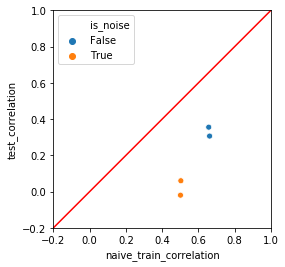

In [16]:
seaborn.scatterplot(x = "naive_train_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

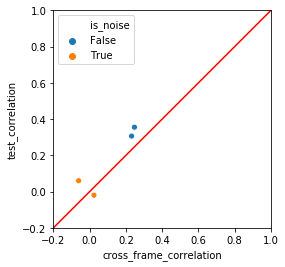

In [17]:
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [18]:
plan.score_frame_.tail()

,variable,treatment,y_aware,PearsonR,significance,vcount,recommended
7,noise_0_deviance_code,deviance_code,True,-0.023576,0.463534,4.0,False
8,noise_0_prevalence_code,prevalence_code,False,0.041896,0.192552,4.0,False
9,noise_1_impact_code,impact_code,True,-0.060471,0.059878,4.0,False
10,noise_1_deviance_code,deviance_code,True,-0.005020,0.875984,4.0,False
11,noise_1_prevalence_code,prevalence_code,False,0.004957,0.877521,4.0,False


In [19]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code', 'var_1_impact_code']

In [20]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [21]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [22]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [23]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [24]:
fitter.fit(naive_train[all_vars], y_train)
plot_train["predict_naive_all_vars"] = fitter.predict(naive_train[all_vars])
plot_test["predict_naive_all_vars"] = fitter.predict(prepared_test[all_vars])

In [25]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_all_vars
0,1.717237,0.561165,0.608341,0.641252
1,1.802630,-0.333592,-0.175873,-0.091345
2,1.571054,-0.279925,-0.288651,-0.210070
3,-1.567557,-0.052943,0.019909,0.167856
4,1.590310,0.278193,0.178558,-0.570365


In [26]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

0.953132843625084


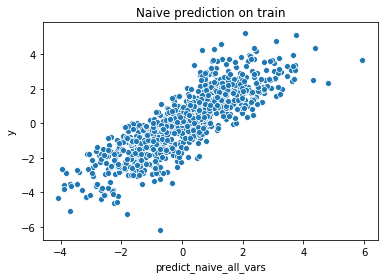

In [27]:
print(rmse(plot_train["predict_naive_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive prediction on train")

1.646686283674642


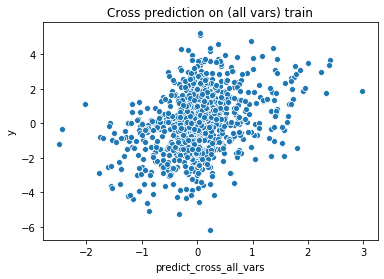

In [28]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

1.6519810579424707


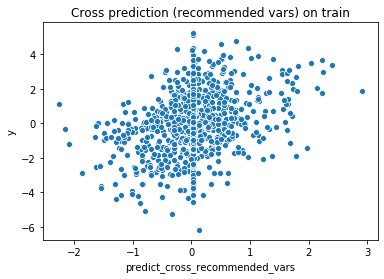

In [29]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

1.6160307752959113



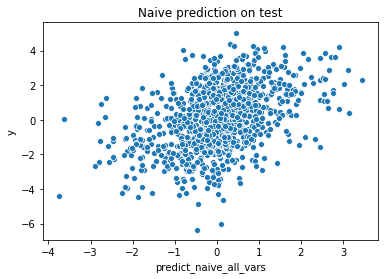

In [30]:
print(rmse(plot_test["predict_naive_all_vars"], plot_test["y"]))
print()
seaborn.scatterplot(x="predict_naive_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive prediction on test")

1.5821409987414368


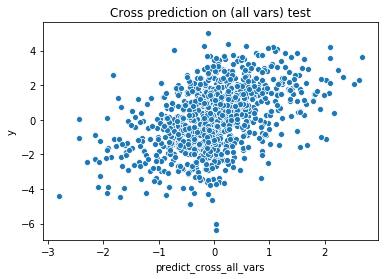

In [31]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

1.5719453602911466


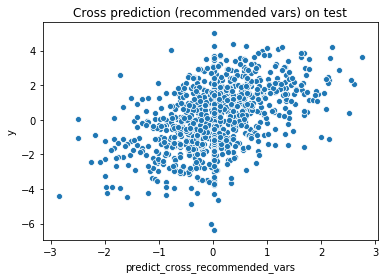

In [32]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [33]:
smf = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train[all_vars])).fit()
smf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     191.6
Date:                Thu, 25 Jul 2019   Prob (F-statistic):          1.79e-244
Time:                        12:12:12   Log-Likelihood:                -1328.4
No. Observations:                 969   AIC:                             2683.
Df Residuals:                     956   BIC:                             2746.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0474      0.141      0.337      0.736      -0.229       0.323
var_0_impact_code           0.8249      0.039     21.185      0.000       0.748       0.901
var_0_deviance_code         0.0060      0.049      0.123      0.902      -0.091       0.103
var_0_prevalence_code     -13.5833     21.279     -0.638      0.523     -55.342      28.175
var_1_impact_code           0.7423      0.040     18.647      0.000       0.664       0.820
var_1_deviance_code         0.0249      0.050      0.496      0.620      -0.074       0.123
var_1_prevalence_code      32.2841     20.042      1.611      0.108      -7.048      71.616
noise_0_impact_code         0.4956      0.057      8.707      0.000       0.384       0.607
noise_0_deviance_code       0.0565      0.038      1.494      0.136      -0.018       0.131
noise_0_prevalence_code     2.8082     22.682      0.124      0.901     -41.704      47.320
noise_1_impact_code         0.5519      0.055      9.948      0.000       0.443       0.661
noise_1_deviance_code      -0.0923      0.040     -2.310      0.021      -0.171      -0.014
noise_1_prevalence_code   -35.4244     23.662     -1.497      0.135     -81.860      11.011
==============================================================================
Omnibus:                       38.527   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.682
Skew:                          -0.139   Prob(JB):                     6.15e-22
Kurtosis:                       4.530   Cond. No.                     2.47e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
smf = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     11.20
Date:                Thu, 25 Jul 2019   Prob (F-statistic):           3.19e-21
Time:                        12:12:12   Log-Likelihood:                -1858.3
No. Observations:                 969   AIC:                             3743.
Df Residuals:                     956   BIC:                             3806.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0204      0.188     -0.109      0.914      -0.388       0.348
var_0_impact_code           0.6519      0.085      7.714      0.000       0.486       0.818
var_0_deviance_code        -0.0262      0.073     -0.359      0.720      -0.169       0.117
var_0_prevalence_code     -11.9342     39.645     -0.301      0.763     -89.735      65.867
var_1_impact_code           0.7123      0.086      8.279      0.000       0.543       0.881
var_1_deviance_code         0.0483      0.078      0.620      0.535      -0.104       0.201
var_1_prevalence_code       3.5379     37.567      0.094      0.925     -70.186      77.262
noise_0_impact_code         0.0127      0.110      0.115      0.909      -0.204       0.229
noise_0_deviance_code      -0.0590      0.060     -0.987      0.324      -0.176       0.058
noise_0_prevalence_code    72.3137     41.280      1.752      0.080      -8.696     153.323
noise_1_impact_code        -0.1434      0.104     -1.375      0.170      -0.348       0.061
noise_1_deviance_code      -0.0117      0.060     -0.194      0.846      -0.130       0.107
noise_1_prevalence_code    -7.6775     45.013     -0.171      0.865     -96.014      80.659
==============================================================================
Omnibus:                        0.320   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.852   Jarque-Bera (JB):                0.231
Skew:                          -0.027   Prob(JB):                        0.891
Kurtosis:                       3.053   Cond. No.                     2.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
params = {'use_hierarchical_estimate':True}
params

{'use_hierarchical_estimate': True}